In [1]:
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from sklearn.datasets import fetch_mldata
%matplotlib inline

<ol>
<li><a href="#Downloading,-Formatting,-and-Verifying-MNIST">Downloading, Formatting, and Verifying MNIST</a></li>
<li><a href="#Fabricating-the-new-dataset-made-from-concatenated-mnist-digits">Fabricating the new dataset made from concatenated mnist digits</a></li>
</ol>

# Downloading, Formatting, and Verifying MNIST
In this section, we 
1. use scikit-learn's `fetch_mldata` to download the MNIST dataset from <a href="mldata.org">mldata.org</a>, 
2. one-hot encode the target variable, and 
3. shuffle the dataset

In [5]:
fetch_mldata('MNIST original', data_home='./')

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [7]:
os.rename('./mldata/', 'MNIST_Data')

In [8]:
mnist = loadmat('./MNIST_Data/mnist-original.mat')
mnist

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun May 21 17:51:55 2017',
 '__version__': '1.0',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[ 0.,  0.,  0., ...,  9.,  9.,  9.]]),
 'mldata_descr_ordering': array([[array(['label'], 
       dtype='<U5'),
         array(['data'], 
       dtype='<U4')]], dtype=object)}

In [9]:
def to_one_hot(num):
    '''Numpy array of digits mapped to a one-hot encoding'''
    num = np.ravel(num).astype(int)
    toreturn = np.zeros(shape=(len(num), 10), dtype=np.int16)
    for i, dig in enumerate(num):
        toreturn[i, dig] = 1
    return toreturn
to_one_hot(np.array([0, 1, 6.0, 7, 8]))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int16)

In [10]:
mnist_data = mnist['data'].T.reshape((-1, 28, 28))
mnist_label = to_one_hot(np.ravel(mnist['label']))

I'm going ahead and shuffling all of the data here before we forget to down the line and potentially mess up all of the training.

In [11]:
np.random.seed(42)
perm = np.random.permutation(np.arange(len(mnist_data), dtype='int'))
mnist_data = mnist_data[perm]
mnist_label = mnist_label[perm]

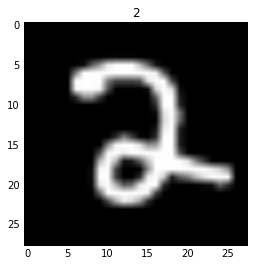

In [12]:
plt.imshow(mnist_data[-1], cmap='gray')
plt.title(mnist_label[-1].argmax())
plt.show()

# Fabricating the new dataset made from concatenated mnist digits
In this section, we fabricate a dataset by, for each $l\in\{1, .., 5\}$, $n$ times randomly selecting $l$ digits and horizontally concatenate them with some random padding to make the length of all resulting images equal to the length of 5 MNIST digits. 

Then, we save the data again as a .mat file. 

In [14]:
max_seq_len = 5
def make_size_n_seqs(n, size):
    idxes = np.round(np.random.uniform(high=len(mnist_data), size=(size, n))).astype('int')
    data = mnist_data[idxes, :]
    labels = mnist_label[idxes]
    
    toreturn = np.zeros((size, 28, max_seq_len*28))
    if not n == max_seq_len:
        extra_room = (max_seq_len - n) * 28
        for i in range(size):
            pad_sections = n + 1
            remaining_room = extra_room
            pad_idx = 0
            for j in range(pad_sections):
                pad_spaces = np.round(np.random.normal(loc=extra_room/pad_sections, scale=np.sqrt(extra_room/pad_sections))).astype('int')
                pad_spaces = min(remaining_room, max(0, pad_spaces))
                
#                 padding = np.round(np.random.uniform(high=255, size=(28, pad_spaces))).astype(int)
                padding = np.zeros((28, pad_spaces)) 

                toreturn[i, :, pad_idx:pad_idx+pad_spaces] = padding
                if j != pad_sections - 1:
                    toreturn[i, :, pad_idx+pad_spaces:pad_idx+pad_spaces+28] = data[i, j, :, :]
                pad_idx += pad_spaces + 28
                remaining_room -= pad_spaces
    else:
        for i in range(size):
            for j in range(n):
                toreturn[i, :, 28*j:(j+1)*28] = data[i, j, :, :]
                
    return toreturn, labels

(10, 28, 140)
(10, 3, 10)


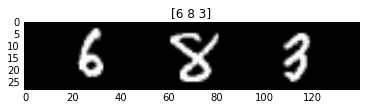

In [15]:
# %%debug
np.random.seed(seed=1964)
dset, labels = make_size_n_seqs(3, 10)
print(dset.shape)
print(labels.shape)
plt.imshow(dset[0], cmap='gray')
plt.title(labels[0].argmax(axis=1))

In [17]:
n_per_num = len(mnist_data) // (1+2+3+4+5)
n_per_num

4666

(23330, 28, 140)
23330 (1, 10)


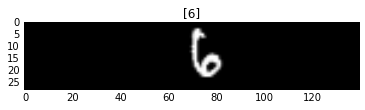

In [18]:
sim_dsets = []
sim_labels = []
for n in range(1, 6):
    dset, labels = make_size_n_seqs(n, n_per_num)
    sim_dsets.append(dset)
    sim_labels.append(labels)
simulated_dataset = np.concatenate(sim_dsets)
simulated_labels = []
for group in sim_labels:
    simulated_labels.extend(list(group))# We don't want to pad the ones with fewer numbers or anything

print(simulated_dataset.shape)
print(len(simulated_labels), simulated_labels[0].shape)
plt.imshow(simulated_dataset[0], cmap='gray')
plt.title(simulated_labels[0].argmax(axis=1))

In [19]:
os.mkdir('./fabricated_mnist_data/')
savemat('./fabricated_mnist_data/data_and_labels.mat', {'data': simulated_dataset, 
                                                        'labels': simulated_labels})